# Geospatial Visualizations with Python

In order to use the geospatial libraries like geopandas and earthpy, it's best to create a new environment, this is because GDAL (geospatial data abstraction library) and PyProj require a custom Windows environment variable that points to package dependencies. For more information follow this link: https://mapscaping.com/python-environment-for-geospatial-programming/

In [31]:
import pandas as pd
import numpy as np

from glob import glob
from osgeo import gdal

import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image 

## Globe Choropleth

In [23]:
# load the country boundary vector data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [6]:
# show the geodataframe
world.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

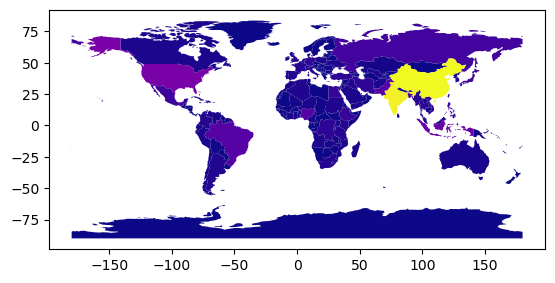

In [39]:
# plot the vector data
world.plot(column='pop_est', cmap='plasma');

In [40]:
# plot more interactive map (does not require geometry)
fig = px.choropleth(world, locations='iso_a3',
                    color='gdp_md_est', 
                    hover_name='name', 
                    animation_frame=None)
fig.show()

## Satelite Data

You can acess satelite data through the EO Browser https://www.sentinel-hub.com/explore/eobrowser/

In [4]:
# Load files by specifing wildcard charecters
bands = glob("EO_Browser_images (1)/*B*.tiff")

In [5]:
bands.sort()
bands

['EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 'EO_Browser_images (1)\\2022-09-27-00_00_2022-09-27-23_59_Sentinel-2_L2A_B12_(Raw).tiff',

In [6]:
# read raster images
l = []
for i in bands:
    with rio.open(i, 'r') as f:
        l.append(f.read(1))

In [7]:
arr_st = np.stack(l)
arr_st.shape

(12, 2003, 2500)

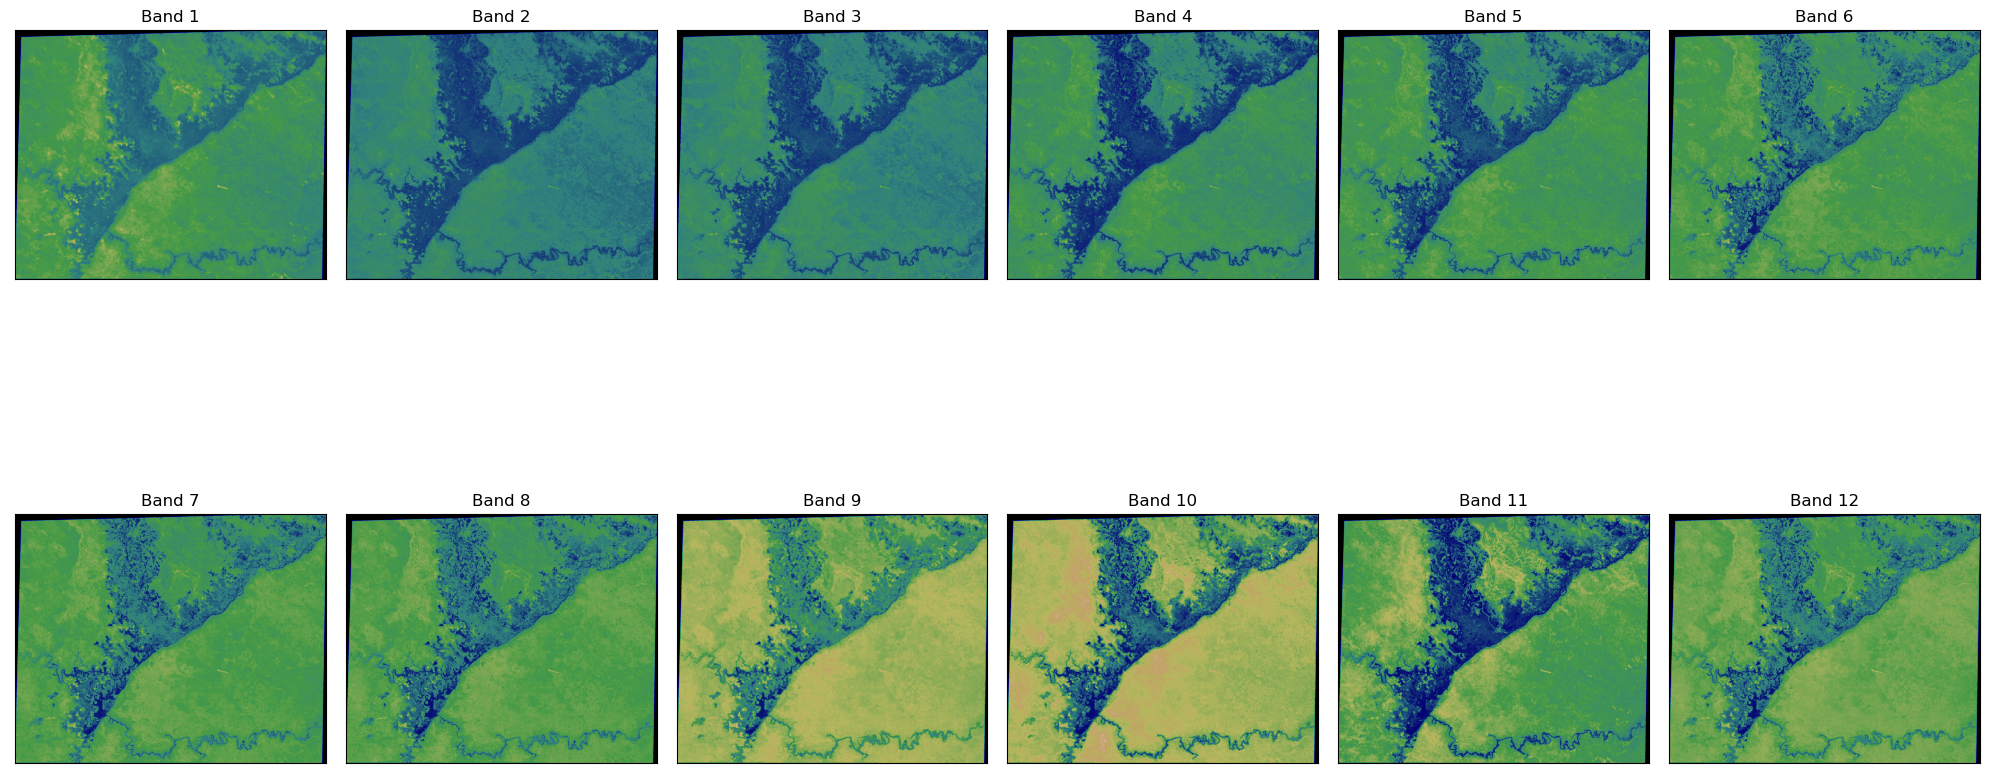

In [8]:
# plot the bands representing different wavelengths 
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()

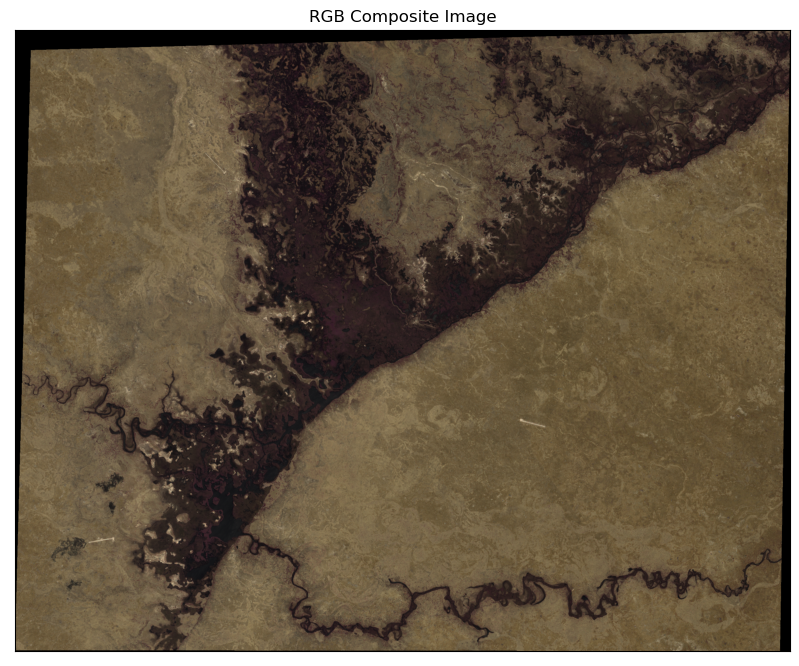

In [52]:
# plot red green blue map
rgb = ep.plot_rgb(arr_st, 
                  rgb=(4,3,2), 
                  figsize=(10, 16), 
                  title='RGB Composite Image'
                  )

plt.show()  

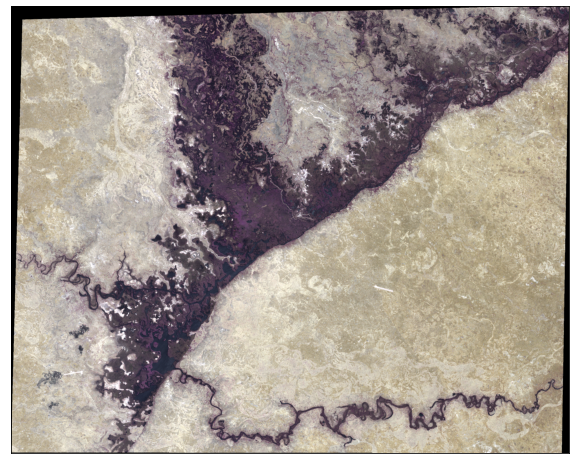

In [26]:
# plot red green blue map with strech
ep.plot_rgb(
    arr_st,
    rgb=(4, 3, 2),
    stretch=True,
    str_clip=0.2,
    figsize=(10, 16),
    title="RGB Composite Image with Stretch Applied",
)

plt.show()

In [11]:
# WATER INDICES 


# Modified Normalized difference water index (MNDWI)

# MNDWI = MNDWI = (Green - SWIR) / (Green + SWIR)
#      Green = pixel values from the green band
#.     SWIR = pixel values from the short-wave infrared band

mndwi = es.normalized_diff(arr_st[2], arr_st[10])

C:\ProgramData\anaconda3\envs\gis_workbench39\lib\site-packages\earthpy\spatial.py:105: RuntimeWarning: invalid value encountered in divide
  n_diff = (b1 - b2) / (b1 + b2)


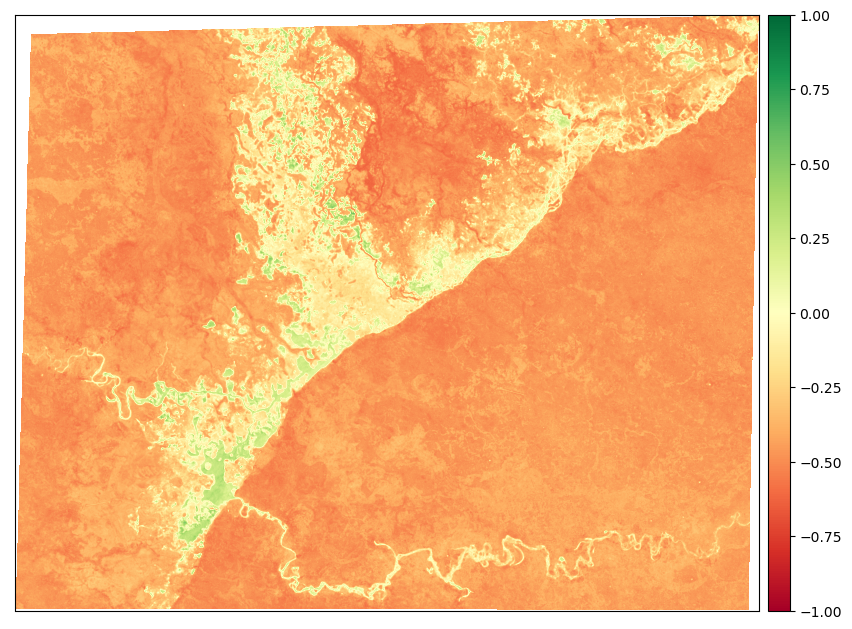

In [12]:
# plot MNDWI layer
ep.plot_bands(mndwi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

In [13]:
# Normalized Differene Moisture Index (NDMI)

#  NDMI = (NIR - SWIR1)/(NIR + SWIR1)
#.  NIR = pixel values from the near infrared band
#.  SWIR1 = pixel values from the short-wave infrared 1 band

ndmi = es.normalized_diff(arr_st[7], arr_st[10])

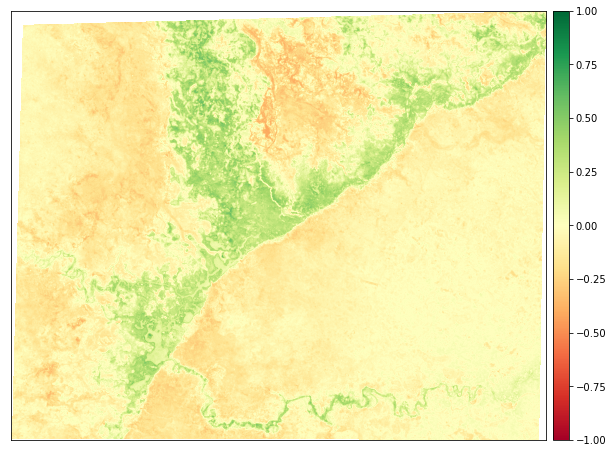

In [32]:
# plot NDMI layer
ep.plot_bands(ndmi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

### Polygon Satelite Image

In order to obtain a specific area as satelite image you need to have a file with the geomatry of the shape. You can then upload the shape to the EO Browser and download data for that shape.

In [41]:
kaza_land_cover = glob("EO_Browser_images_KAZA/*True_Color.tiff")

In [42]:
arr_land_cover = np.array([rio.open(kaza_land_cover[0], 'r').read(1)])

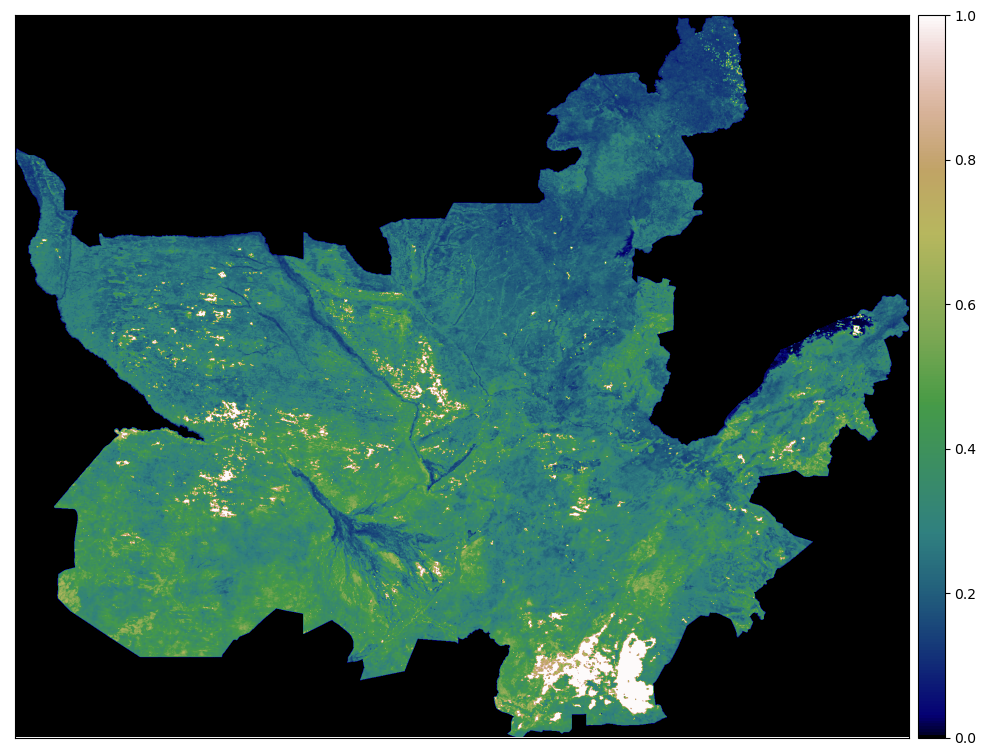

<AxesSubplot: >

In [43]:
ep.plot_bands(arr_land_cover, cmap = "gist_earth")

## Polygon Choropleth

Using the same geometry shape we can visualize the polygon with geopandas and plot different vizualisations with additional data.

In [53]:
kaza_proj_areas = gpd.read_file('KAZA2.geojson')

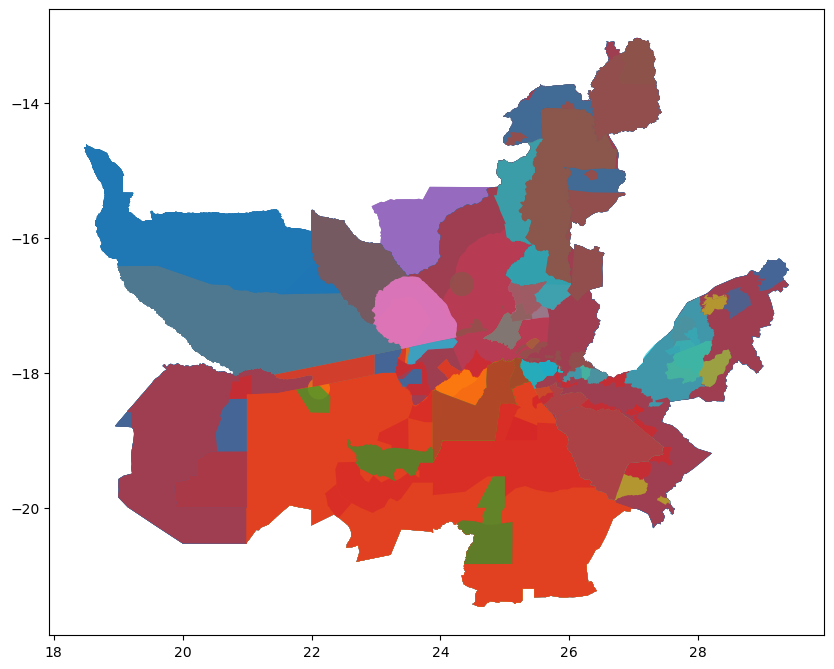

In [55]:
kaza_proj_areas.plot(column='name', alpha=0.7, figsize=(10,16));